In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
import json
import msacorrnet as mcn
from copy import deepcopy
from sklearn.manifold import MDS
import matplotlib.cm as cm
from scipy.spatial import distance
import random
import matplotlib as mpl
from itertools import groupby
import topcorr
import fnmatch
import os
import glob
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import itertools
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap

In [3]:
time = int(14400)

file = "data/hts-cp-double-fault-4hr/cpu_usage.json"

f = open(file)

data = json.load(f)
f.close()

f_dict = {}
data = data['data']['result']
for ent in range(len(data)):
    if data[ent]['metric']['id'] != "/":
        f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
        f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
        f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]

for service in f_dict:
    if data[0]["metric"]["__name__"] == "container_memory_usage_bytes":
        pass
    else:
        temp = [0]
        for i in range(1, np.shape(f_dict[service])[0]):
            temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
        f_dict[service][:, 1] = deepcopy(temp)
        f_dict[service][:, 1] = mcn.sub_sample_zeros(f_dict[service][:, 1])

max_len = 0
for i in f_dict:
    if len(f_dict[i]) > max_len:
        max_len = len(f_dict[i])

aligned_data = mcn.align_data(f_dict, 5, time)
service_list = []
for s in aligned_data:
    service_list.append(s)
s_list = []
for s in aligned_data:
    s_list.append(s)
X = np.zeros((int((time / 5) ), len(s_list)))
ind = 0
for s in service_list:
    X[:, ind] = aligned_data[s][:, 1]
    ind += 1

In [4]:
# remove misc data
misc_ms = ["nginx*","jaeger*"]
for ms in misc_ms:
    matched_indices = [index for index, string in enumerate(service_list) if fnmatch.fnmatchcase(string, ms)]
    if len(matched_indices) > 0:
        s_list.pop(matched_indices[0])
        service_list.pop(matched_indices[0])
        X = np.delete(X,matched_indices[0],axis=1)

In [5]:
dir = os.getcwd()+'/data/hts-cp-double-fault-4hr'
os.chdir(dir)
files = glob.glob('traces_*.json')
spans_list = []
for file in tqdm(files):
    with open(dir+"\\"+file, 'r') as file:
        data = json.load(file)
    
    spans = data['data']
    
    # Iterate through each trace and span to extract the necessary data
    for trace in data['data']:
        temp = {'startTime': 0, 'duration': 0}
        for span in trace['spans']:
            if span['duration'] > temp['duration']:
                temp['startTime'] = span['startTime']
                temp['duration'] = span['duration']
                
        spans_list.append(temp)


# Convert spans list to calls per second
df = pd.DataFrame(spans_list)
df['startTime'] = pd.to_datetime(df['startTime'], unit='us')
df['duration'] = df['duration'] / 1e3
df = df.set_index('startTime')
df = df[~df.index.duplicated(keep='first')] # remove overlapping traces
average_response_time_per_second = df['duration'].resample('5s').mean()
calls_per_second = df.resample('5s').size()

100%|██████████| 241/241 [00:11<00:00, 21.06it/s]


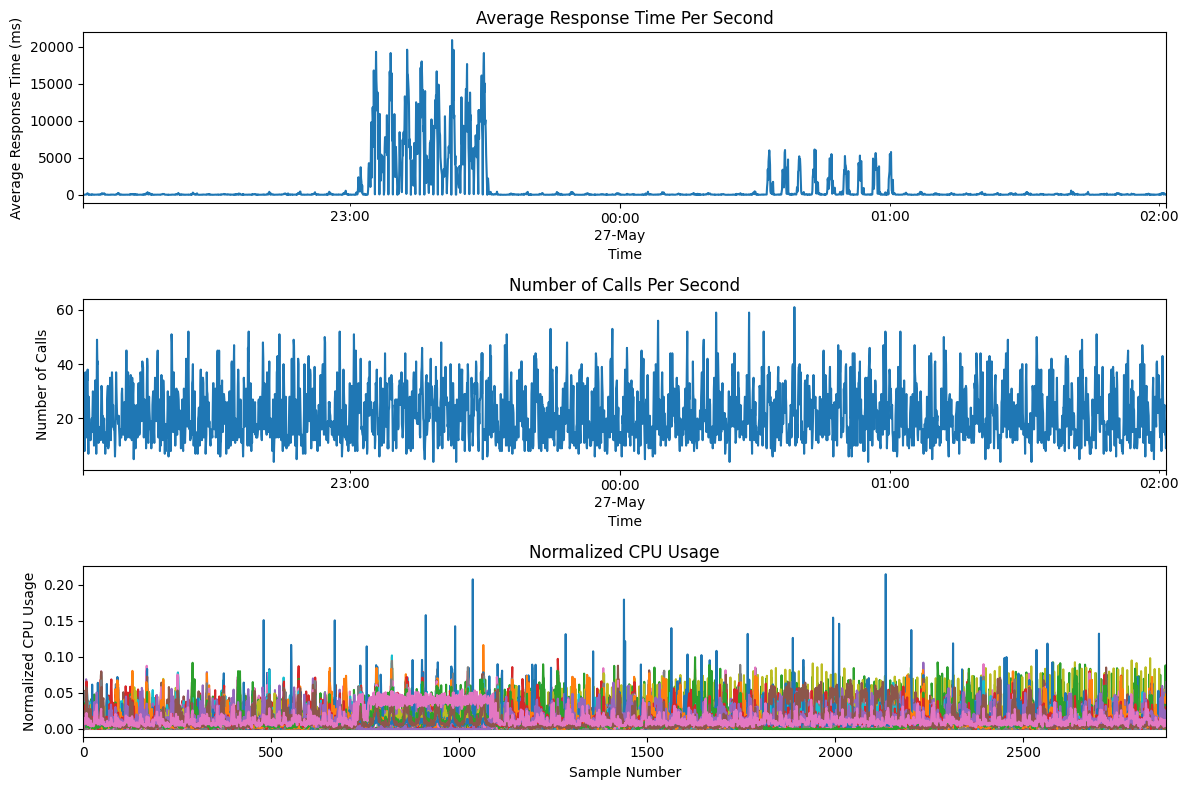

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1) 
average_response_time_per_second.plot()
plt.title('Average Response Time Per Second')
plt.xlabel('Time')
plt.ylabel('Average Response Time (ms)')
plt.subplot(3, 1, 2)
calls_per_second.plot()
plt.title('Number of Calls Per Second')
plt.xlabel('Time')
plt.ylabel('Number of Calls')
plt.subplot(3,1,3)
plt.plot(normalize(X,axis=0))
plt.xlim(0,int(14400/5))
plt.title('Normalized CPU Usage')
plt.xlabel('Sample Number')
plt.ylabel('Normalized CPU Usage')
plt.tight_layout()
plt.show()

In [7]:
win = 360
step = 1
Xc = deepcopy(X)
Xdiff = np.diff(Xc[:,:],axis=0)
Xdiff = normalize(Xdiff,axis=0)
r_dict = mcn.rolling_window(Xdiff[:,:], win, "tapered", step, 0.3, "tmfg", "pearsons")

D:\Documents\PhD\Code\MSACorrNet-INFOCOM-2025\msacorrnet.py:57: RuntimeWarning: invalid value encountered in true_divide
  R = temp / np.sqrt(np.dot(R, R.T))


In [9]:
r_pos = {}
for corr in r_dict:
    r_pos[corr]=deepcopy(r_dict[corr])
    r_pos[corr] += 1

spectra = mcn.all_spectra(r_pos, True)
all_es = spectra.T
all_es = all_es[:,:-1]

In [10]:
scaling="LMDS"
if scaling == "LMDS":
    landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
    dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
    coords = mcn.LMDS(dist, landmarks, 2)

elif scaling == "MDS":
    dist = distance.cdist(all_es, all_es, 'euclidean')
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
    coords = mds.fit_transform(dist)

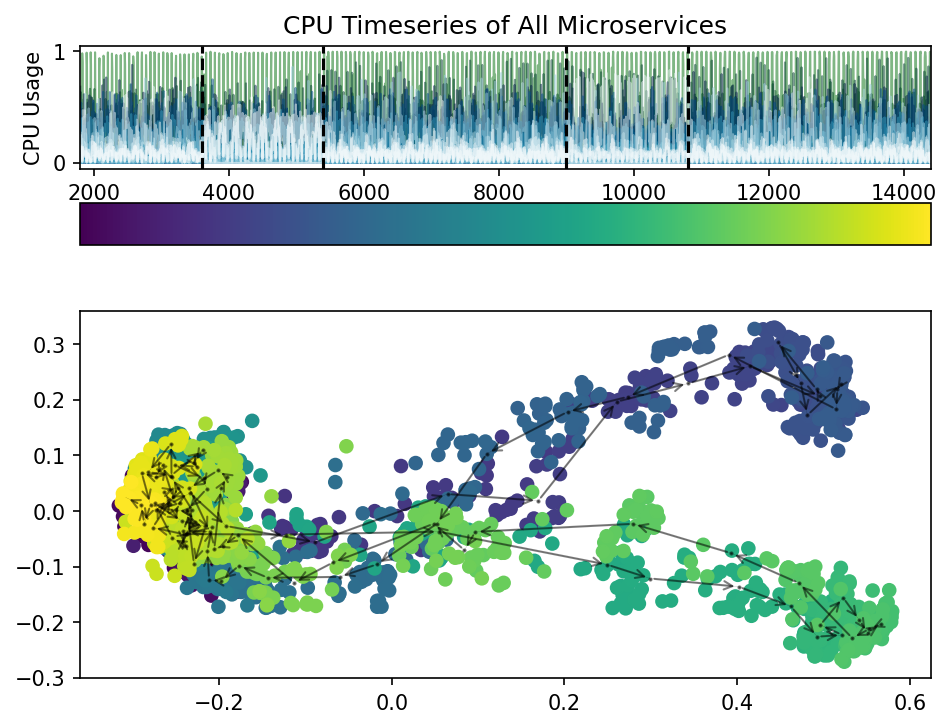

In [11]:
# Finalized plot
fig, ax = plt.subplot_mosaic('AAA;BBB;CCC', gridspec_kw=dict(
    height_ratios=[1, 0.1, 3]), dpi=150)

n = len(r_pos)
cmap_type = "viridis"
type_color = "ocean"
cmap = cm.get_cmap(type_color, n)
t = np.arange(0, n)
plt.tight_layout()
fin = int(np.floor(len(X)/step)*step)
ax['A'].set_ylabel('CPU Usage')
ax['A'].set_title('CPU Timeseries of All Microservices')
ax['A'].set_xlabel("Time (s)")
ax['A'].plot(range(win*5,len(Xc[:,:])*5,5),normalize(Xc[win:,:]*100,axis=1), alpha=0.5, linewidth=1)
ax['A'].set_xlim(xmin=win*5)
ax['A'].set_xlim(xmax=len(X[:,:])*5)
cmap = cm.get_cmap(type_color, np.shape(X)[1])
colors = [cmap(i) for i in range(np.shape(X)[1])]
for i, j in enumerate(ax['A'].lines):
    j.set_color(colors[i])
    
ax['A'].axvline((3600), color='k',linestyle='--')
ax['A'].axvline((3600+1800), color='k',linestyle='--')
ax['A'].axvline((9000), color='k',linestyle='--')
ax['A'].axvline((9000+1800), color='k',linestyle='--')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(int(win*5), time),
                                          cmap=cmap_type),
                    ax=ax['B'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
                    )
ax['B'].set_visible(False)

cbar.ax.tick_params(size=0)
cbar.set_ticks([])

ax['C'].scatter(coords[:, 0], coords[:, 1], c=t, cmap=cmap_type, alpha=1)

n_pts = 25
if n_pts > 0:
    prev_x = np.mean(coords[0:n_pts, 0])
    prev_y = np.mean(coords[0:n_pts, 1])
    for i in range(10, len(coords), n_pts):
        curr_x = np.mean(coords[i:i+n_pts, 0])
        curr_y = np.mean(coords[i:i+n_pts, 1])
        ax['C'].plot([prev_x, curr_x], [prev_y, curr_y], 'k', alpha=0.5, linewidth=0.1)
        ax['C'].plot(prev_x, prev_y, 'k.', markersize=2, alpha=0.5)
        ax['C'].annotate("",
                              xytext=(prev_x, prev_y),
                              xy=(curr_x, curr_y),
                              arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linewidth=1))
        prev_x = curr_x
        prev_y = curr_y


plt.show()

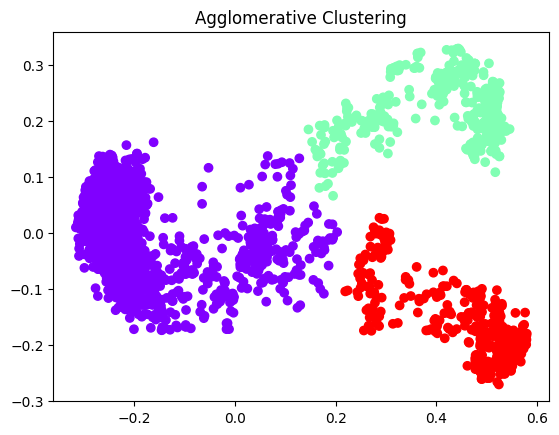

In [18]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="average").fit(coords)

# Plot the results
plt.scatter(coords[:, 0], coords[:, 1], c=clustering.labels_, cmap='rainbow', marker='o')
plt.title('Agglomerative Clustering')
plt.show()

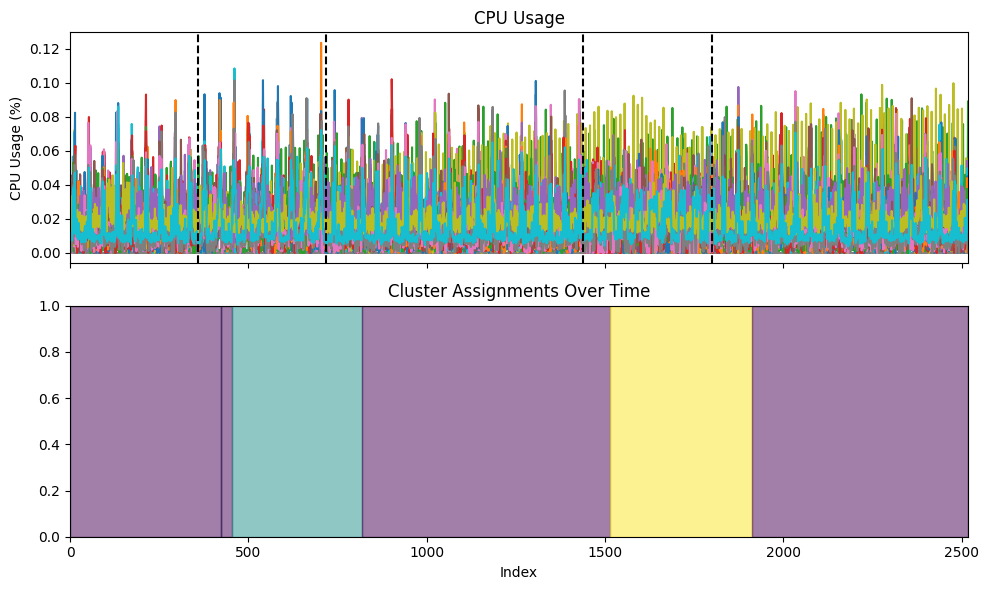

In [19]:
from matplotlib.cm import get_cmap
def plot_time_series_and_clusters(data, indices, cluster_labels):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Plot the first feature of the original time series data on the first subplot
    ax[0].plot(indices, normalize(data[:, :40]*100, axis=0), linestyle='-')
    ax[0].set_title('CPU Usage')
    ax[0].set_ylabel('CPU Usage (%)')
    ax[0].axvline((3600/5)-361, color='k', linestyle='--')
    ax[0].axvline((5400/5)-361, color='k', linestyle='--')
    ax[0].axvline((9000/5)-361, color='k', linestyle='--')
    ax[0].axvline((10800/5)-361, color='k', linestyle='--')
    # Generate a color map for the clusters
    n_clusters = np.unique(cluster_labels).size
    cmap = get_cmap('viridis', n_clusters)
    colors = {label: cmap(i) for i, label in enumerate(np.unique(cluster_labels))}

    # Plot cluster time series on the second subplot
    prev_label = cluster_labels[0]
    start_index = indices[0]
    for i in range(1, len(cluster_labels)):
        if cluster_labels[i] != prev_label or i == len(cluster_labels) - 1:
            end_index = indices[i] if cluster_labels[i] != prev_label else indices[i] + 1
            ax[1].axvspan(start_index, end_index, color=colors[prev_label], alpha=0.5)
            start_index = indices[i]
            prev_label = cluster_labels[i]
    
    ax[1].set_title('Cluster Assignments Over Time')
    ax[1].set_xlabel('Index')
    ax[1].set_xlim(indices[0], indices[-1])

    plt.tight_layout()
    plt.show()

plot_time_series_and_clusters(X[360:-1,:],range(len(clustering.labels_)), clustering.labels_)